# Importing the necessary packages

In [55]:
# Data Analysis and Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Train-Test Splitting and Hyper-parameter Tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# Preformance Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Getting rid of Warnings
import warnings
warnings.filterwarnings("ignore")

# Setting Configs
%matplotlib inline

# Data Reading

In [56]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv


In [110]:
# Reading the train and test datasets
train_df = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/train.csv")
test_df = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/test.csv")
sample_submission = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-3/sample_submission.csv")

In [58]:
train_df.head()

,id,phrase,feature_1,feature_2,feature_3,sentiment
0,0,It may as well be called `` Jar-Jar Binks : Th...,14.0,5.0,7.0,0
1,1,You have to see it .,6.0,1.0,NaN,2
2,2,... either you 're willing to go with this cla...,16.0,0.0,6.0,1
3,3,Watching Harris ham it up while physically and...,37.0,NaN,3.0,1
4,4,Pete 's screenplay manages to find that real n...,20.0,1.0,4.0,2


# Taking a look on the training dataset

In [59]:
train_df.shape

(7000, 6)

In [60]:
test_df.shape

(1700, 5)

# Gathering the information about the various features in the training set

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         7000 non-null   int64  
 1   phrase     7000 non-null   object 
 2   feature_1  6088 non-null   float64
 3   feature_2  5896 non-null   float64
 4   feature_3  5938 non-null   float64
 5   sentiment  7000 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 328.3+ KB


There are 5 numerical (2 integer and 3 float) features in our training set, remaining 1 feature is categorical.

# Descriptive statistics of the numerical features of the dataset

In [62]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7000.0,3499.500000,2020.870275,0.0,1749.75,3499.5,5249.25,6999.0
feature_1,6088.0,19.025624,9.303562,1.0,12.00,18.0,25.00,52.0
feature_2,5896.0,1.996608,1.634858,0.0,1.00,1.0,3.00,19.0
feature_3,5938.0,3.334119,2.321154,0.0,2.00,3.0,4.00,19.0
sentiment,7000.0,1.041143,0.898010,0.0,0.00,1.0,2.00,2.0


# Missing values: identify & handle

In [63]:
print("Missing values in TRAIN:")
print(train_df.isnull().sum())

print("\nMissing values in TEST:")
print(test_df.isnull().sum())

Missing values in TRAIN:
id              0
phrase          0
feature_1     912
feature_2    1104
feature_3    1062
sentiment       0
dtype: int64

Missing values in TEST:
id             0
phrase         0
feature_1    222
feature_2    318
feature_3     90
dtype: int64


In [64]:
# Handle missing text by filling with empty string
train_df["phrase"] = train_df["phrase"].fillna("")
test_df["phrase"] = test_df["phrase"].fillna("")

In [65]:
# Drop rows with missing target (if any)
before_drop = train_df.shape[0]
train_df = train_df.dropna(subset=["sentiment"])
after_drop = train_df.shape[0]

print(f"Dropped {before_drop - after_drop} rows with missing target (if any).")

Dropped 0 rows with missing target (if any).


In [66]:
# Using mean imputer for feature cols
feature_cols = ["feature_1", "feature_2", "feature_3"]
mi = SimpleImputer(strategy="median")

train_df[feature_cols] = mi.fit_transform(train_df[feature_cols])
test_df[feature_cols] = mi.transform(test_df[feature_cols])

In [67]:
print("Missing values in TRAIN:")
print(train_df.isnull().sum())

print("\nMissing values in TEST:")
print(test_df.isnull().sum())

Missing values in TRAIN:
id           0
phrase       0
feature_1    0
feature_2    0
feature_3    0
sentiment    0
dtype: int64

Missing values in TEST:
id           0
phrase       0
feature_1    0
feature_2    0
feature_3    0
dtype: int64


# Duplicates: identify & handle

In [68]:
# Removing 'id' column as it's not needed
train_df = train_df.drop("id", axis=1)
test_df = test_df.drop("id", axis=1)

In [69]:
# Drop duplicate rows (if any)
before_drop = train_df.shape[0]
train_df = train_df.drop_duplicates()
after_drop = train_df.shape[0]

print(f"Dropped {before_drop - after_drop} duplicated rows.")

Dropped 96 duplicated rows.


# Outlier detection & handling

In [70]:
# Extracting text length feature
def add_text_length_features(df):
    df = df.copy()
    df["length_chars"] = df["phrase"].apply(len)
    df["length_words"] = df["phrase"].apply(lambda x: len(str(x).split()))
    return df

train_df = add_text_length_features(train_df)
test_df = add_text_length_features(test_df)

numeric_engineered = ["length_chars", "length_words"]

# Combine original + engineered numeric columns
numeric_cols = feature_cols + numeric_engineered

print("Numeric columns used:", numeric_cols)

Numeric columns used: ['feature_1', 'feature_2', 'feature_3', 'length_chars', 'length_words']


In [71]:
# IQR method to detect outliers
def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

for col in numeric_engineered:
    lb, ub = detect_outliers_iqr(train_df[col])
    outliers = ((train_df[col] < lb) | (train_df[col] > ub)).sum()
    print(f"{col}: lower={lb:.2f}, upper={ub:.2f}, outliers={outliers}")

length_chars: lower=-53.00, upper=251.00, outliers=26
length_words: lower=-7.50, upper=44.50, outliers=50


In [72]:
# Instead of dropping, we clip extreme values to keep all rows but reduce impact
for col in numeric_engineered:
    lb, ub = detect_outliers_iqr(train_df[col])
    train_df[col] = np.clip(train_df[col], lb, ub)
    test_df[col]  = np.clip(test_df[col], lb, ub)

# Visualizations

Sentiment value counts:
sentiment
0    2658
1    1318
2    2928
Name: count, dtype: int64


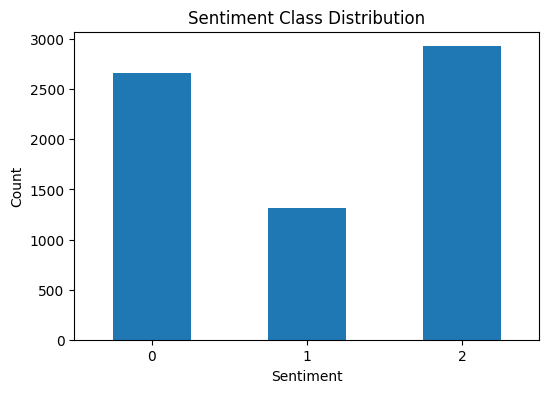

In [73]:
# 1. Sentiment class distribution
sent_counts = train_df["sentiment"].value_counts().sort_index()
print("Sentiment value counts:")
print(sent_counts)

plt.figure(figsize=(6,4))
sent_counts.plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

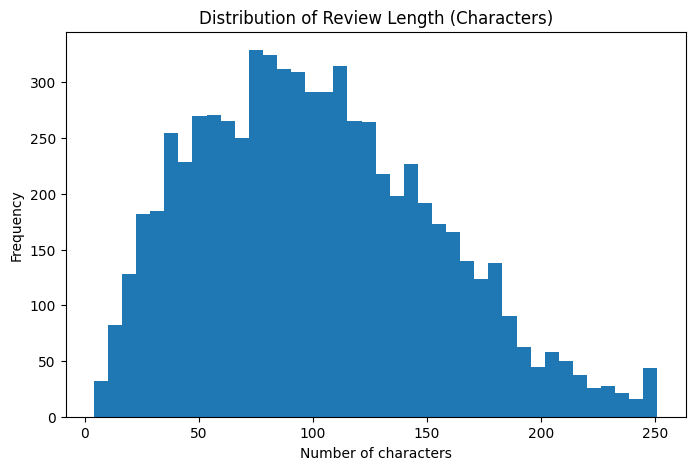

In [74]:
# 2. Histogram of review length (characters)
plt.figure(figsize=(8,5))
plt.hist(train_df["length_chars"], bins=40)
plt.title("Distribution of Review Length (Characters)")
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.show()

<Figure size 800x500 with 0 Axes>

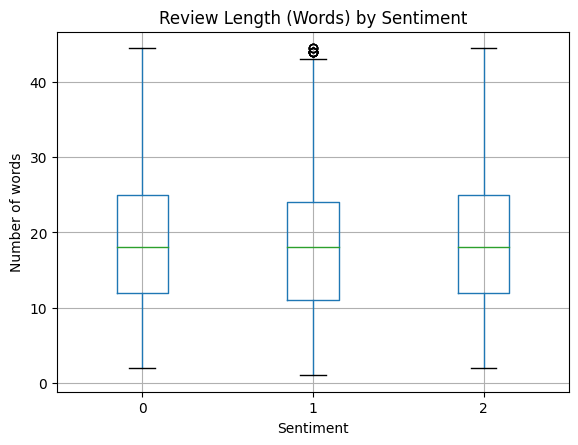

In [75]:
# 3. Boxplot of review length (words) by sentiment
plt.figure(figsize=(8,5))
train_df.boxplot(column="length_words", by="sentiment")
plt.title("Review Length (Words) by Sentiment")
plt.suptitle("")  # remove automatic title
plt.xlabel("Sentiment")
plt.ylabel("Number of words")
plt.show()

# Train-validation split

In [76]:
X = train_df.drop("sentiment", axis=1)
y = train_df["sentiment"].copy()

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=150906,
    stratify=y
)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

X_train shape: (5523, 6)
X_valid shape: (1381, 6)


# Preprocessing: TF-IDF for text + scaling numeric features

In [77]:
# Text transformer: word-level TF-IDF (we'll add stronger models later)
text_transformer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),   # unigrams + bigrams
    max_df=0.9,
    min_df=2
)

In [78]:
# Numeric transformer: impute missing + standardize
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

In [79]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "phrase"),
        ("num", numeric_transformer, numeric_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('text',
                                 TfidfVectorizer(max_df=0.9, min_df=2,
                                                 ngram_range=(1, 2),
                                                 stop_words='english'),
                                 'phrase'),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['feature_1', 'feature_2', 'feature_3',
                                  'length_chars', 'length_words'])])

# Model building

In [105]:
results_list = []
fitted_models = {}
preds_valid = {}

# Helper function
def evaluate_model(name, model, X_train, y_train, X_valid, y_valid, results_list):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred, average="weighted")
    print(f"\nModel: {name}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-score (weighted): {f1:.4f}")
    results_list.append({
        "model": name,
        "accuracy": acc,
        "f1_weighted": f1
    })
    return model, y_pred

In [83]:
# 1. Logistic Regression
pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=150906, multi_class="auto"))
])
pipe_lr

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf',
                 LogisticRegression(max_iter=2000, random_state=150906))])

In [85]:
# 2. Linear SVC
pipe_lsvc = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC(random_state=150906))
])
pipe_lsvc

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf', LinearSVC(random_state=150906))])

In [87]:
# 3. Multinomial Naive Bayes (text only, NB expects non-negative data)
pipe_nb = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=2
    )),
    ("clf", MultinomialNB())
])
pipe_nb

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [88]:
# 4. SGDClassifier (linear model with log-loss)
pipe_sgd = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SGDClassifier(loss="log_loss", random_state=150906))
])
pipe_sgd

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf', SGDClassifier(loss='log_loss', random_state=150906))])

In [89]:
# 5. RandomForest
pipe_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=150906,
        n_jobs=-1
    ))
])
pipe_rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=150906))])

In [90]:
# 6. GradientBoosting
pipe_gb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", GradientBoostingClassifier(random_state=150906))
])
pipe_gb

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf', GradientBoostingClassifier(random_state=150906))])

In [92]:
# 7. XGBoost (multi-class)
num_classes = train_df["sentiment"].nunique()
pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=150906,
        n_jobs=-1
    ))
])
pipe_xgb

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               cols...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=-1, num_class=3,
                               num_parallel_tree=None, ...))])

In [93]:
# 8. PassiveAggressive
pipe_pa = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", PassiveAggressiveClassifier(random_state=150906))
])
pipe_pa

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=2,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'phrase'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'length_chars',
                                                   'length_words'])])),
                ('clf', PassiveAggressiveClassifier(random_state=150906))])

In [102]:
# 9. Character n-gram TF-IDF + Logistic Regression
char_vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True,
    max_features=200000
)
pipe_char_lr = Pipeline(steps=[
    ("tfidf", char_vectorizer),
    ("clf", LogisticRegression(
        max_iter=4000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])
pipe_char_lr

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.9,
                                 max_features=200000, min_df=2,
                                 ngram_range=(3, 5), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(max_iter=4000, multi_class='multinomial',
                                    n_jobs=-1))])

In [106]:
models_to_run = [
    ("Logistic Regression", pipe_lr, False),
    ("Linear SVC",         pipe_lsvc, False),
    ("Multinomial NB",     pipe_nb,  True),  # text-only
    ("SGDClassifier",      pipe_sgd, False),
    ("RandomForest",       pipe_rf,  False),
    ("GradientBoosting",   pipe_gb,  False),
    ("XGBoost",            pipe_xgb, False),
    ("PassiveAggressive",  pipe_pa,  False),
    ("CHAR-NGRAM LogReg",  pipe_char_lr, True)
]

In [107]:
# Fit and evaluate each model
for name, model, text_only in models_to_run:
    if text_only:
        model_trained, y_pred = evaluate_model(name, model, X_train["phrase"], y_train, X_valid["phrase"], y_valid, results_list)
    else:
        model_trained, y_pred = evaluate_model(name, model, X_train, y_train, X_valid, y_valid, results_list)
    fitted_models[name] = model_trained
    preds_valid[name] = y_pred

results_df = pd.DataFrame(results_list).sort_values(by="accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


Model: Logistic Regression
  Accuracy: 0.6365
  F1-score (weighted): 0.5824

Model: Linear SVC
  Accuracy: 0.5974
  F1-score (weighted): 0.5728

Model: Multinomial NB
  Accuracy: 0.6256
  F1-score (weighted): 0.5588

Model: SGDClassifier
  Accuracy: 0.5655
  F1-score (weighted): 0.5278

Model: RandomForest
  Accuracy: 0.5771
  F1-score (weighted): 0.5269

Model: GradientBoosting
  Accuracy: 0.5424
  F1-score (weighted): 0.4886

Model: XGBoost
  Accuracy: 0.5684
  F1-score (weighted): 0.5306

Model: PassiveAggressive
  Accuracy: 0.5554
  F1-score (weighted): 0.5469

Model: CHAR-NGRAM LogReg
  Accuracy: 0.6452
  F1-score (weighted): 0.5937


,model,accuracy,f1_weighted
0,CHAR-NGRAM LogReg,0.645185,0.593747
1,Logistic Regression,0.636495,0.582380
2,Multinomial NB,0.625634,0.558839
3,Linear SVC,0.597393,0.572795
4,RandomForest,0.577118,0.526910
5,XGBoost,0.568429,0.530565
6,SGDClassifier,0.565532,0.527768
7,PassiveAggressive,0.555395,0.546881
8,GradientBoosting,0.542361,0.488585


# Hyperparameter Tuning — Logistic Regression, LinearSVC, XGBoost

In [98]:
# 1. Logistic Regression tuning
param_grid_lr = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0],
    "clf__class_weight": [None, "balanced"],
    "clf__penalty": ["l2"]
}

pipe_lr_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(
        max_iter=3000,
        random_state=150906,
        multi_class="auto"
    ))
])

grid_lr = GridSearchCV(
    estimator=pipe_lr_base,
    param_grid=param_grid_lr,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
print("Best LogisticRegression params:", grid_lr.best_params_)
print("Best LogisticRegression CV accuracy:", grid_lr.best_score_)

y_pred_lr = grid_lr.predict(X_valid)
acc_lr = accuracy_score(y_valid, y_pred_lr)
f1_lr = f1_score(y_valid, y_pred_lr, average="weighted")
print(f"LogisticRegression tuned - Val Accuracy: {acc_lr:.4f}, F1: {f1_lr:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best LogisticRegression params: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__penalty': 'l2'}
Best LogisticRegression CV accuracy: 0.6056495507902158
LogisticRegression tuned - Val Accuracy: 0.6365, F1: 0.5824


In [99]:
# 2. Linear SVC tuning
param_grid_lsvc = {
    "clf__C": [0.25, 0.5, 1.0, 2.0, 4.0]
}

pipe_lsvc_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC(random_state=150906))
])

grid_lsvc = GridSearchCV(
    estimator=pipe_lsvc_base,
    param_grid=param_grid_lsvc,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lsvc.fit(X_train, y_train)
print("Best LinearSVC params:", grid_lsvc.best_params_)
print("Best LinearSVC CV accuracy:", grid_lsvc.best_score_)

y_pred_lsvc = grid_lsvc.predict(X_valid)
acc_lsvc = accuracy_score(y_valid, y_pred_lsvc)
f1_lsvc = f1_score(y_valid, y_pred_lsvc, average="weighted")
print(f"LinearSVC tuned - Val Accuracy: {acc_lsvc:.4f}, F1: {f1_lsvc:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best LinearSVC params: {'clf__C': 0.25}
Best LinearSVC CV accuracy: 0.6016658469407831
LinearSVC tuned - Val Accuracy: 0.6314, F1: 0.5848


In [101]:
# 3. XGBoost tuning
param_grid_xgb = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [4, 6],
    "clf__learning_rate": [0.05, 0.1]
}

pipe_xgb_base = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb.XGBClassifier(
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=150906,
        n_jobs=-1
    ))
])

grid_xgb = GridSearchCV(
    estimator=pipe_xgb_base,
    param_grid=param_grid_xgb,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB CV accuracy:", grid_xgb.best_score_)

y_pred_xgb = grid_xgb.predict(X_valid)
acc_xgb = accuracy_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb, average="weighted")
print(f"XGB tuned - Val Accuracy: {acc_xgb:.4f}, F1: {f1_xgb:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300}
Best XGB CV accuracy: 0.530327720441789
XGB tuned - Val Accuracy: 0.5684, F1: 0.5306


# Comparison of model performances

In [108]:
comparison_rows = []

# Base models (from results_df)
for _, row in results_df.iterrows():
    comparison_rows.append({
        "model": row["model"],
        "accuracy": row["accuracy"],
        "f1_weighted": row["f1_weighted"]
    })

# Tuned models
comparison_rows.append({
    "model": "Logistic Regression (tuned)",
    "accuracy": acc_lr,
    "f1_weighted": f1_lr
})

comparison_rows.append({
    "model": "Linear SVC (tuned)",
    "accuracy": acc_lsvc,
    "f1_weighted": f1_lsvc
})

comparison_rows.append({
    "model": "XGBoost (tuned)",
    "accuracy": acc_xgb,
    "f1_weighted": f1_xgb
})

comparison_df = pd.DataFrame(comparison_rows).sort_values(by="accuracy", ascending=False)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df

,model,accuracy,f1_weighted
0,CHAR-NGRAM LogReg,0.645185,0.593747
1,Logistic Regression,0.636495,0.582380
2,Logistic Regression (tuned),0.636495,0.582380
3,Linear SVC (tuned),0.631427,0.584789
4,Multinomial NB,0.625634,0.558839
5,Linear SVC,0.597393,0.572795
6,RandomForest,0.577118,0.526910
7,XGBoost,0.568429,0.530565
8,XGBoost (tuned),0.568429,0.530565
9,SGDClassifier,0.565532,0.527768


# Final Kaggle Submission - using CHAR-NGRAM LogReg model

In [111]:
# Train best model on FULL training data (text only)
pipe_char_lr.fit(train_df["phrase"], train_df["sentiment"])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.9,
                                 max_features=200000, min_df=2,
                                 ngram_range=(3, 5), sublinear_tf=True)),
                ('clf',
                 LogisticRegression(max_iter=4000, multi_class='multinomial',
                                    n_jobs=-1))])

In [112]:
test_predictions = pipe_char_lr.predict(test_df["phrase"])

print("Test predictions length:", len(test_predictions))
print("Sample submission length:", len(sample_submission))

submission = sample_submission.copy()

submission.iloc[:, 1] = test_predictions

print("\nSubmission head:")
print(submission.head())
print("\nSubmission shape:", submission.shape)

submission.to_csv("submission.csv", index=False)
print("\nFINAL submission.csv saved successfully!")

Test predictions length: 1700
Sample submission length: 1700

Submission head:
   id  sentiment
0   0          0
1   1          2
2   2          2
3   3          2
4   4          0

Submission shape: (1700, 2)

FINAL submission.csv saved successfully!
